Задание №1. Реализация и исследование модели Хольта-Уинтерса

Выполнила: Расулова Динара

▎1. Цель работы

• Реализовать модель Хольта-Уинтерса на языке Python (или другом языке высокого уровня) с возможностью тюнинга гиперпараметров.

▎2. Постановка задачи

• Создать программу, которая:

  • Принимает на вход:

    • Временной ряд.

    • Параметры сглаживания модели.

    • Длину периода в сезонах.

    • Размер горизонта прогнозирования (один или два периода).

  • Выдает на выходе:

    • Параметры модели (коэффициенты линейной компоненты, последний коэффициент сезонности).

    • Прогнозные значения.

  • В режиме тюнинга дополнительно предоставляет:

    • Значения параметров сглаживания.

    • Длину сезона (если подбирается).

▎3. Данные

• Использовать любой временной ряд, кроме представленного в видеозаписи.

• Рекомендуемые источники данных:

  • Сайт Росстата: rosstat.gov.ru

  • Сервисы трейдинга с видимой сезонностью.

• Минимальные требования к данным:

  • Минимальное число сезонов в периоде: 4.

  • Минимальное число периодов: 5.

▎4. Выходные данные

• Программа должна выводить:

  • Параметры модели Хольта-Уинтерса.

  • Прогноз на один или более периодов в зависимости от длины исходного ряда.

▎5. Форма представления

• Разместить материалы на GitHub в отдельной ветке проекта:

  • Код программы.

  • Описание в файле README, включающее:

    • Цель работы.

    • Постановка задачи.

    • Краткое описание модели.

    • Экраны или скриншоты работы программы (можно использовать Jupyter Notebook или Google Colab).

▎6. Защита работы

• На защите ответить на 2 вопроса:

  • По содержанию темы.

  • По коду программы.

▎7. Оценка

• Основная часть:

  • 6 баллов за выполнение и размещение материалов на GitHub.

  • 4 балла за защиту.

• Расширенный вариант (тюнинг гиперпараметров):

  • До 4 баллов за параметры сглаживания и длину сезона с использованием методов машинного обучения.

• Подкаст:

  • Аудиозапись длительностью до 90 секунд, делящаяся впечатлениями о выполненной работе (что получилось, трудности, новые знания) — 1 балл.

▎8. Особенности

• Допускается использование библиотек для работы с временными рядами и данными.

• Нельзя использовать библиотеки для модели Хольта-Уинтерса, но можно применять библиотеки для тюнинга гиперпараметров.

 Импорт необходимых библиотек

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

Импорт данных

S&P 500, также известный как Standard & Poor's 500, представляет собой фондовый индекс, который включает акции 500 крупнейших по капитализации публичных компаний, торгующихся на американских фондовых биржах, таких как NYSE и NASDAQ.

Основные характеристики S&P 500

- Капитализация: Компании, входящие в индекс, должны иметь рыночную капитализацию более $5 миллиардов и ликвидность не менее 250,000 акций, торгуемых в месяц.
- Секторы: Индекс охватывает 11 различных секторов экономики, включая технологии, здравоохранение, финансы и энергетику. Это делает его более представительным по сравнению с другими индексами, такими как Dow Jones Industrial Average, который включает только 30 компаний.
- Метод расчета: S&P 500 является взвешенным по капитализации индексом, что означает, что компании с большей капитализацией имеют больший вес в расчете индекса

https://ru.investing.com/indices/us-spx-500

In [72]:
# Загрузка данных S&P 500
data = pd.read_csv('/content/S&P 500 (SPX).csv')

# Преобразование колонки Price в числовой формат
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Удаление строк с NaN значениями (если есть)
data.dropna(subset=['Price'], inplace=True)

# Основная информация о датасете
print(data.info())

# Статистическое описание числовых столбцов
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    357 non-null    object 
 1   Price   357 non-null    float64
 2   Open    357 non-null    float64
 3   Max     357 non-null    float64
 4   Min     357 non-null    float64
dtypes: float64(4), object(1)
memory usage: 14.1+ KB
None
             Price         Open          Max          Min
count   357.000000   357.000000   357.000000   357.000000
mean   1895.731653  1882.294818  1947.311261  1817.108543
std    1198.707662  1185.660334  1226.177189  1147.473091
min     487.400000   470.400000   489.200000   469.300000
25%    1111.900000  1111.800000  1146.300000  1074.700000
50%    1377.900000  1372.700000  1415.300000  1324.300000
75%    2411.800000  2388.500000  2418.710000  2328.950000
max    5762.480000  5757.730000  5878.460000  5674.000000


Data     0
Price    0
Open     0
Max      0
Min      0
dtype: int64


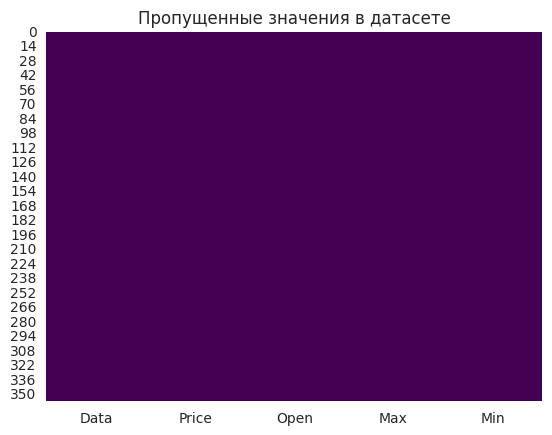

In [73]:
import seaborn as sns

 # Проверка на наличие пропущенных значений
print(data.isnull().sum())
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Пропущенные значения в датасете")
plt.show()

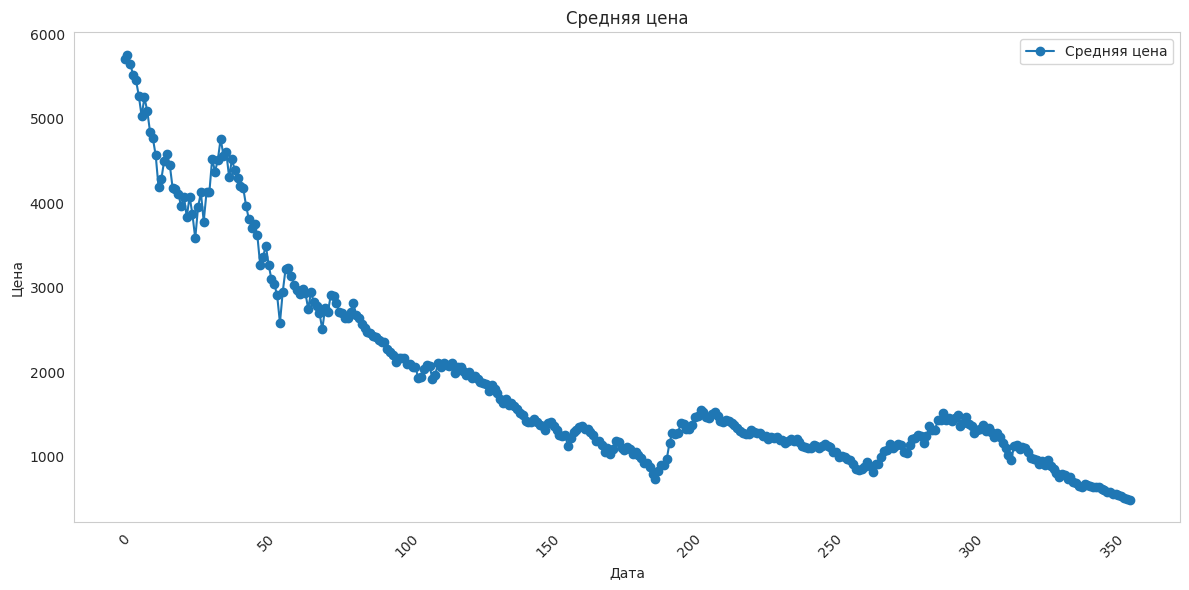

Тест Дики-Фуллера:
Статистика ADF: -2.762917469519889, p-значение: 0.06376908329911121
Тест КПСС:
Статистика KPSS: 2.386446547945953, p-значение: 0.01


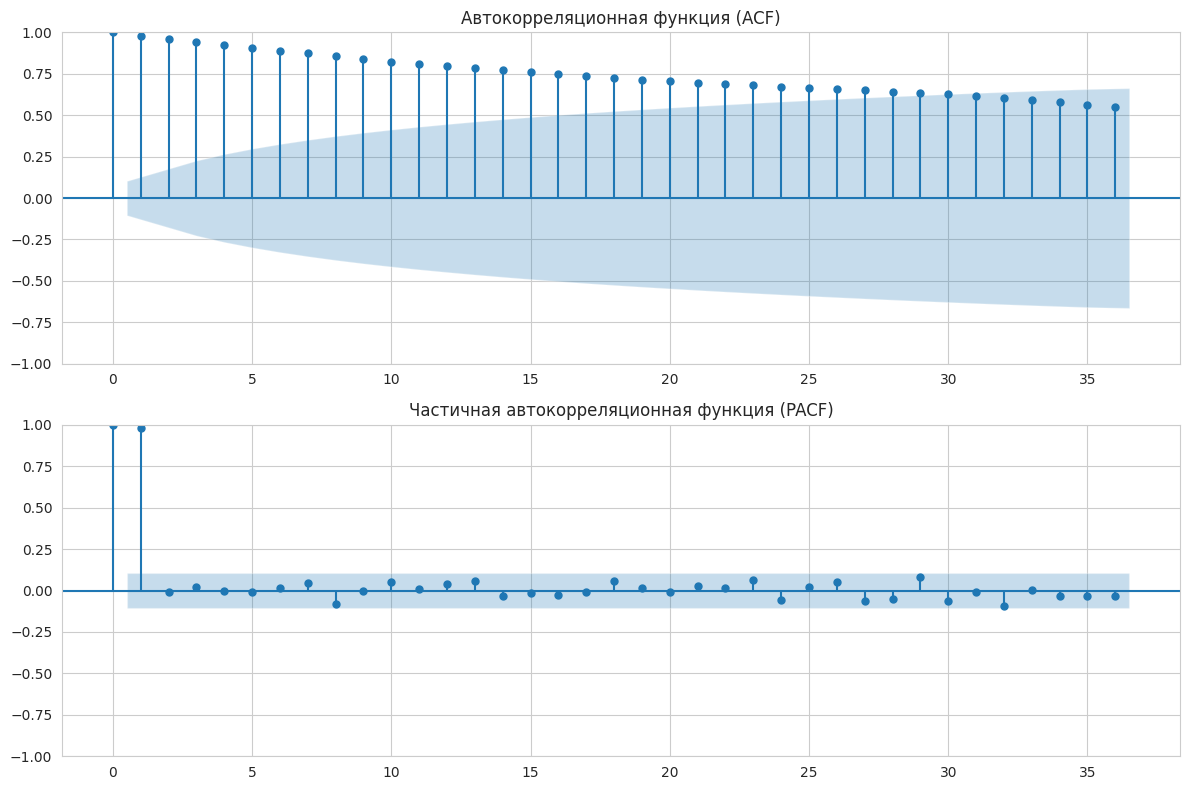

In [74]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



Price_data = data['Price']

# Функция для тестирования на наличие сезонности и стационарности
def test_stationarity(data):
    adf_result = adfuller(data)
    kpss_result = kpss(data, regression='c')

    print('Тест Дики-Фуллера:')
    print(f'Статистика ADF: {adf_result[0]}, p-значение: {adf_result[1]}')

    print('Тест КПСС:')
    print(f'Статистика KPSS: {kpss_result[0]}, p-значение: {kpss_result[1]}')



# Визуализация временного ряда
def plot_time_series(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, marker='o', label='Средняя цена')
    plt.title('Средняя цена')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Построение графика ACF и PACF
def plot_acf_pacf(data, lags=36):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(data, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title('Автокорреляционная функция (ACF)')

    plot_pacf(data, lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title('Частичная автокорреляционная функция (PACF)')

    plt.tight_layout()
    plt.show()

# Выполнение анализа
plot_time_series(Price_data)
test_stationarity(Price_data)
plot_acf_pacf(Price_data)


Проверим на стационарность

На основе результатов тестов Дики-Фуллера и КПСС можно сделать следующие выводы:

**Тест Дики-Фуллера (ADF)**: В данном случае p-значение (0.064) больше уровня значимости 0.05, что указывает на то, что мы не можем отвергнуть нулевую гипотезу о наличии единичного корня. Это означает, что временной ряд, скорее всего, не стационарен.

**Тест КПСС**:Здесь p-значение (0.01) меньше уровня значимости 0.05, что позволяет отвергнуть нулевую гипотезу о стационарности временного ряда. Это говорит о том, что ряд не является стационарным.

**Общий вывод**: Оба теста указывают на то, что временной ряд не является стационарным. Это может означать, что в ряде присутствует тренд или сезонность.

Реализация модели Хольта-Уинтерса

In [75]:
class HoltWinters:
    def __init__(self, alpha, beta, gamma, seasonal_periods):
        self.alpha = alpha  # уровень сглаживания
        self.beta = beta    # сглаживание тренда
        self.gamma = gamma   # сглаживание сезонности
        self.seasonal_periods = seasonal_periods

    def fit(self, y):
        n = len(y)
        self.level = y[0]
        self.trend = y[1] - y[0]
        self.seasonal = [y[i] - self.level for i in range(self.seasonal_periods)]

        self.forecasts = []
        for t in range(n):
            if t == 0:
                forecast = self.level + self.trend + self.seasonal[t % self.seasonal_periods]
            else:
                forecast = (self.level + self.trend) + self.seasonal[t % self.seasonal_periods]

            self.forecasts.append(forecast)

            # Обновление уровня, тренда и сезонности
            prev_level = self.level
            self.level = (self.alpha * y[t]) + ((1 - self.alpha) * (self.level + self.trend))
            self.trend = (self.beta * (self.level - prev_level)) + ((1 - self.beta) * self.trend)
            self.seasonal[t % self.seasonal_periods] = (self.gamma * (y[t] - self.level)) + ((1 - self.gamma) * self.seasonal[t % self.seasonal_periods])

    def predict(self, periods):
        last_level = self.level
        last_trend = self.trend
        seasonal = self.seasonal.copy()

        predictions = []
        for i in range(periods):
            forecast = last_level + last_trend + seasonal[(len(predictions) + len(seasonal)) % len(seasonal)]
            predictions.append(forecast)
            last_level += last_trend

        return predictions


Функция для тюнинга гиперпараметров

In [76]:
def tune_holt_winters(y, param_grid):
    best_rmse = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        model = HoltWinters(params['alpha'], params['beta'], params['gamma'], params['seasonal_periods'])
        model.fit(y)

        # Оценка модели на последнем периоде
        rmse = np.sqrt(mean_squared_error(y, model.forecasts))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    return best_params, best_rmse

Визуализация


Forecasted Values:
Day 1: 5899.00
Day 2: 5938.33
Day 3: 5927.06
Day 4: 6124.74
Day 5: 6249.45
Day 6: 6357.88
Day 7: 6423.60
Day 8: 6462.93
Day 9: 6451.66
Day 10: 6649.34
Day 11: 6774.05
Day 12: 6882.48


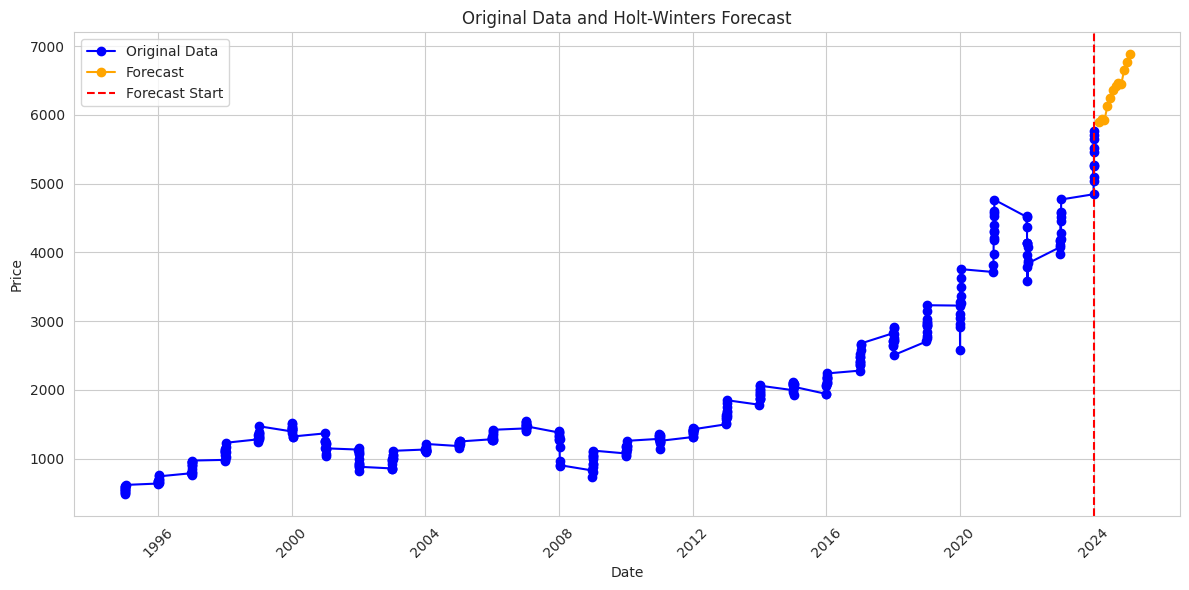

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class HoltWinters:
    def __init__(self, alpha, beta, gamma, seasonal_periods):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.seasonal_periods = seasonal_periods

    def fit(self, y):
        n = len(y)
        self.level = y[0]
        self.trend = y[1] - y[0]
        self.seasonal = [y[i] - self.level for i in range(self.seasonal_periods)]

        self.forecasts = []
        for t in range(n):
            if t == 0:
                forecast = self.level + self.trend + self.seasonal[t % self.seasonal_periods]
            else:
                forecast = (self.level + self.trend) + self.seasonal[t % self.seasonal_periods]

            self.forecasts.append(forecast)

            prev_level = self.level
            self.level = (self.alpha * y[t]) + ((1 - self.alpha) * (self.level + self.trend))
            self.trend = (self.beta * (self.level - prev_level)) + ((1 - self.beta) * self.trend)
            self.seasonal[t % self.seasonal_periods] = (self.gamma * (y[t] - self.level)) + ((1 - self.gamma) * self.seasonal[t % self.seasonal_periods])

    def predict(self, periods):
        last_level = self.level
        last_trend = self.trend
        seasonal = self.seasonal.copy()

        predictions = []
        for i in range(periods):
            forecast = last_level + last_trend + seasonal[(len(predictions) + len(seasonal)) % len(seasonal)]
            predictions.append(forecast)
            last_level += last_trend

        return predictions

def main(data, alpha=0.2, beta=0.1, gamma=0.3, seasonal_periods=12, forecast_periods=12):
    # Сортировка данных по дате
    data['Data'] = pd.to_datetime(data['Data'])
    data.sort_values('Data', inplace=True)

    y = data['Price'].values
    model = HoltWinters(alpha, beta, gamma, seasonal_periods)
    model.fit(y)

    # Прогнозирование
    forecasts = model.predict(forecast_periods)
    print("\nForecasted Values:")
    for i, forecast in enumerate(forecasts):
        print(f"Day {i+1}: {forecast:.2f}")
    # Визуализация исходных данных и прогноза на одном графике
    plt.figure(figsize=(12, 6))
    plt.plot(data['Data'], y, label='Original Data', color='blue', marker='o')

    # Создание индекса для прогнозируемых значений
    forecast_index = pd.date_range(start=data['Data'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

    plt.plot(forecast_index, forecasts, label='Forecast', color='orange', marker='o')

    plt.title('Original Data and Holt-Winters Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.axvline(x=data['Data'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Запуск модели
main(data, alpha=0.2, beta=0.1, gamma=0.3, seasonal_periods=6, forecast_periods=12)


Тюнинг

Best parameters: {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.3, 'seasonal_periods': 6}
Best score (RMSE): 462.51438063579144

Model Parameters:
Alpha: 0.6
Beta: 0.2
Gamma: 0.3
Last Seasonal Coefficient: 34.054703246439956

Forecasted Values:
Day 1: 5869.75
Day 2: 5935.36
Day 3: 5988.72
Day 4: 6174.26
Day 5: 6264.37
Day 6: 6346.79
Day 7: 6412.46
Day 8: 6478.07
Day 9: 6531.43
Day 10: 6716.97
Day 11: 6807.08
Day 12: 6889.50


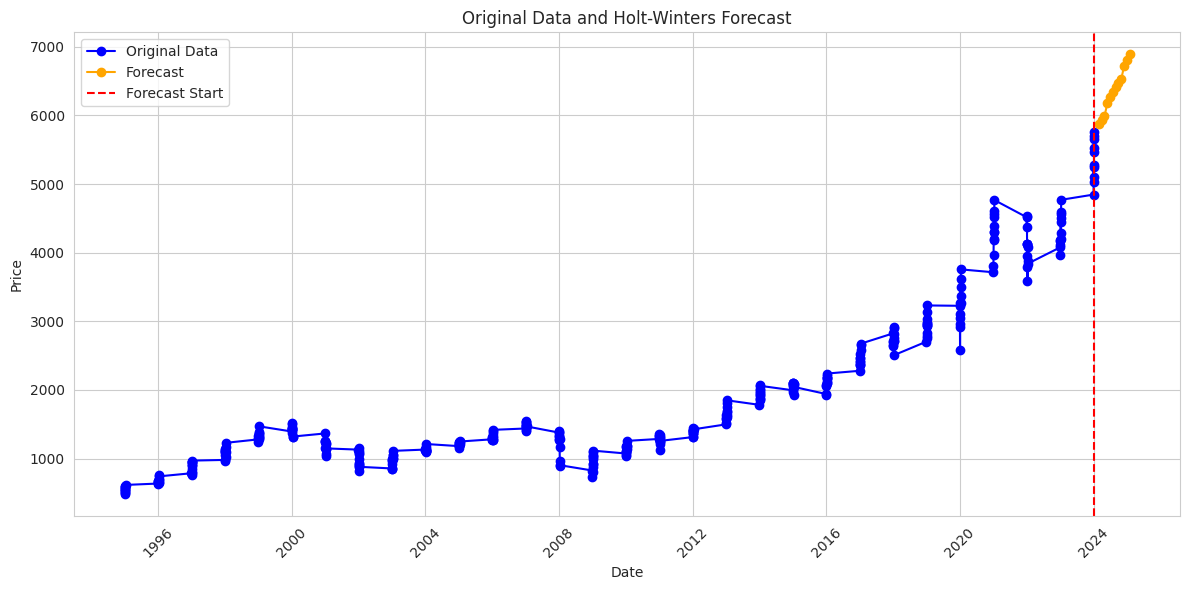

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

class HoltWinters:
    def __init__(self, alpha, beta, gamma, seasonal_periods):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.seasonal_periods = seasonal_periods

    def fit(self, y):
        n = len(y)
        self.level = y[0]
        self.trend = y[1] - y[0]
        self.seasonal = [y[i] - self.level for i in range(self.seasonal_periods)]

        self.forecasts = []
        for t in range(n):
            if t == 0:
                forecast = self.level + self.trend + self.seasonal[t % self.seasonal_periods]
            else:
                forecast = (self.level + self.trend) + self.seasonal[t % self.seasonal_periods]

            self.forecasts.append(forecast)

            prev_level = self.level
            self.level = (self.alpha * y[t]) + ((1 - self.alpha) * (self.level + self.trend))
            self.trend = (self.beta * (self.level - prev_level)) + ((1 - self.beta) * self.trend)
            self.seasonal[t % self.seasonal_periods] = (self.gamma * (y[t] - self.level)) + ((1 - self.gamma) * self.seasonal[t % self.seasonal_periods])

    def predict(self, periods):
        last_level = self.level
        last_trend = self.trend
        seasonal = self.seasonal.copy()

        predictions = []
        for i in range(periods):
            forecast = last_level + last_trend + seasonal[(len(predictions) + len(seasonal)) % len(seasonal)]
            predictions.append(forecast)
            last_level += last_trend

        return predictions

    def score(self, y_true, y_pred):
        # Используем среднеквадратичную ошибку (RMSE) как метрику оценки
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

def main(data, forecast_periods=12):
    # Сортировка данных по дате
    data['Data'] = pd.to_datetime(data['Data'])
    data.sort_values('Data', inplace=True)

    y = data['Price'].values

    # Параметры для GridSearch
    param_grid = {
        'alpha': [0.1, 0.2, 0.3,0.4,0.5,0.6],
        'beta': [0.1, 0.2, 0.3,0.4,0.5,0.6],
        'gamma': [0.1, 0.2, 0.3,0.4,0.5,0.6],
        'seasonal_periods': [6, 24]
    }

    best_score = float('inf')
    best_params = {}

    # Кросс-валидация по временным рядам
    tscv = TimeSeriesSplit(n_splits=5)

    for seasonal_periods in param_grid['seasonal_periods']:
        for alpha in param_grid['alpha']:
            for beta in param_grid['beta']:
                for gamma in param_grid['gamma']:
                    model = HoltWinters(alpha, beta, gamma, seasonal_periods)
                    scores = []

                    for train_index, test_index in tscv.split(y):
                        train, test = y[train_index], y[test_index]
                        model.fit(train)
                        predictions = model.predict(len(test))
                        score = model.score(test, predictions)
                        scores.append(score)

                    mean_score = np.mean(scores)
                    if mean_score < best_score:
                        best_score = mean_score
                        best_params = {
                            'alpha': alpha,
                            'beta': beta,
                            'gamma': gamma,
                            'seasonal_periods': seasonal_periods
                        }

    print("Best parameters:", best_params)
    print("Best score (RMSE):", best_score)

    # Обучение модели с лучшими параметрами на всех данных
    best_model = HoltWinters(**best_params)
    best_model.fit(y)

    # Прогнозирование
    forecasts = best_model.predict(forecast_periods)
     # Вывод параметров модели и прогнозных значений
    print("\nModel Parameters:")
    print(f"Alpha: {best_model.alpha}")
    print(f"Beta: {best_model.beta}")
    print(f"Gamma: {best_model.gamma}")
    print(f"Last Seasonal Coefficient: {best_model.seasonal[-1]}")

    print("\nForecasted Values:")
    for i, forecast in enumerate(forecasts):
        print(f"Day {i+1}: {forecast:.2f}")
    # Визуализация исходных данных и прогноза на одном графике
    plt.figure(figsize=(12, 6))
    plt.plot(data['Data'], y, label='Original Data', color='blue', marker='o')

    # Создание индекса для прогнозируемых значений
    forecast_index = pd.date_range(start=data['Data'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

    plt.plot(forecast_index, forecasts, label='Forecast', color='orange', marker='o')

    plt.title('Original Data and Holt-Winters Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.axvline(x=data['Data'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Запуск модели
main(data, forecast_periods=12)


А если взять данные за 6 мясяцев по дням

In [28]:
# Загрузка данных S&P 500
data = pd.read_csv('/content/data - Лист1.csv')

# Преобразование колонки Price в числовой формат
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Удаление строк с NaN значениями (если есть)
data.dropna(subset=['Price'], inplace=True)

# Основная информация о датасете
print(data.info())

# Статистическое описание числовых столбцов
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    128 non-null    object 
 1   Price   128 non-null    float64
 2   Open    128 non-null    float64
 3   Max     128 non-null    float64
 4   Min     128 non-null    float64
dtypes: float64(4), object(1)
memory usage: 5.1+ KB
None
             Price         Open          Max          Min
count   128.000000   128.000000   128.000000   128.000000
mean   5613.583359  5612.952422  5638.447969  5584.891484
std     203.979528   204.116498   199.992185   206.918755
min    5186.330000  5151.140000  5250.890000  5119.260000
25%    5464.350000  5470.002500  5490.150000  5439.912500
50%    5596.440000  5603.215000  5631.930000  5582.750000
75%    5766.872500  5758.852500  5777.365000  5724.250000
max    6014.070000  6008.860000  6020.750000  5992.320000


Data     0
Price    0
Open     0
Max      0
Min      0
dtype: int64


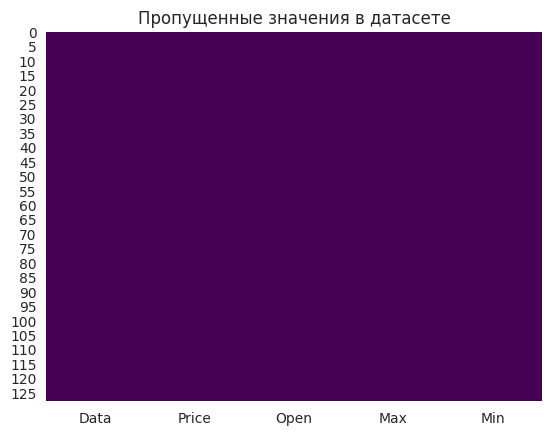

In [29]:
import seaborn as sns

 # Проверка на наличие пропущенных значений
print(data.isnull().sum())
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Пропущенные значения в датасете")
plt.show()

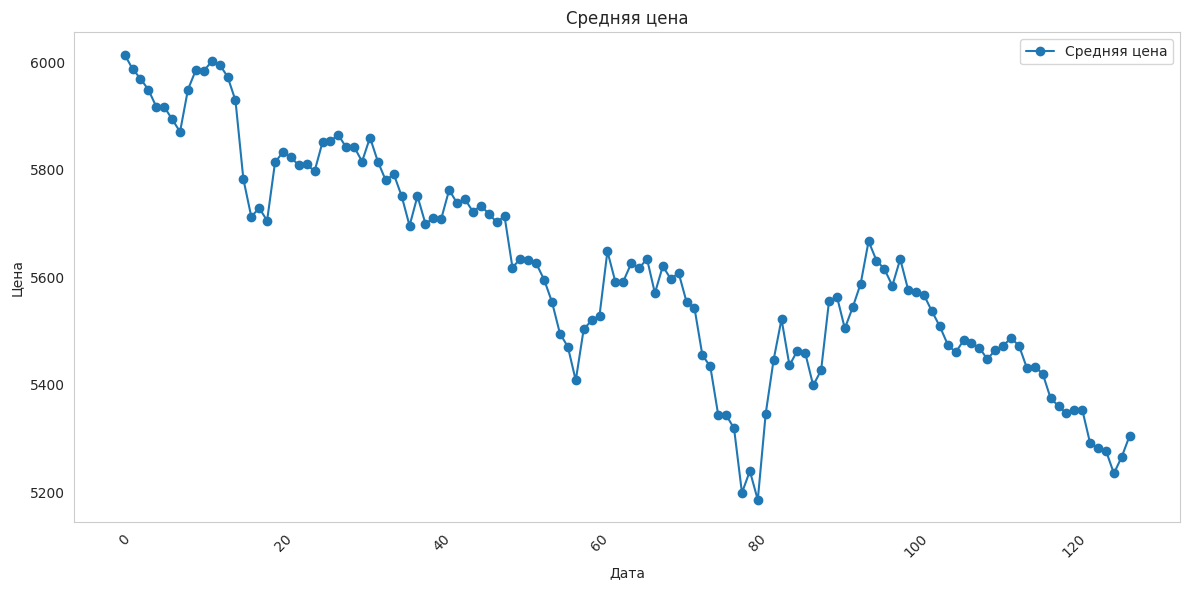

Тест Дики-Фуллера:
Статистика ADF: -1.6202736200036962, p-значение: 0.47258585228435435
Тест КПСС:
Статистика KPSS: 1.5836129766368212, p-значение: 0.01


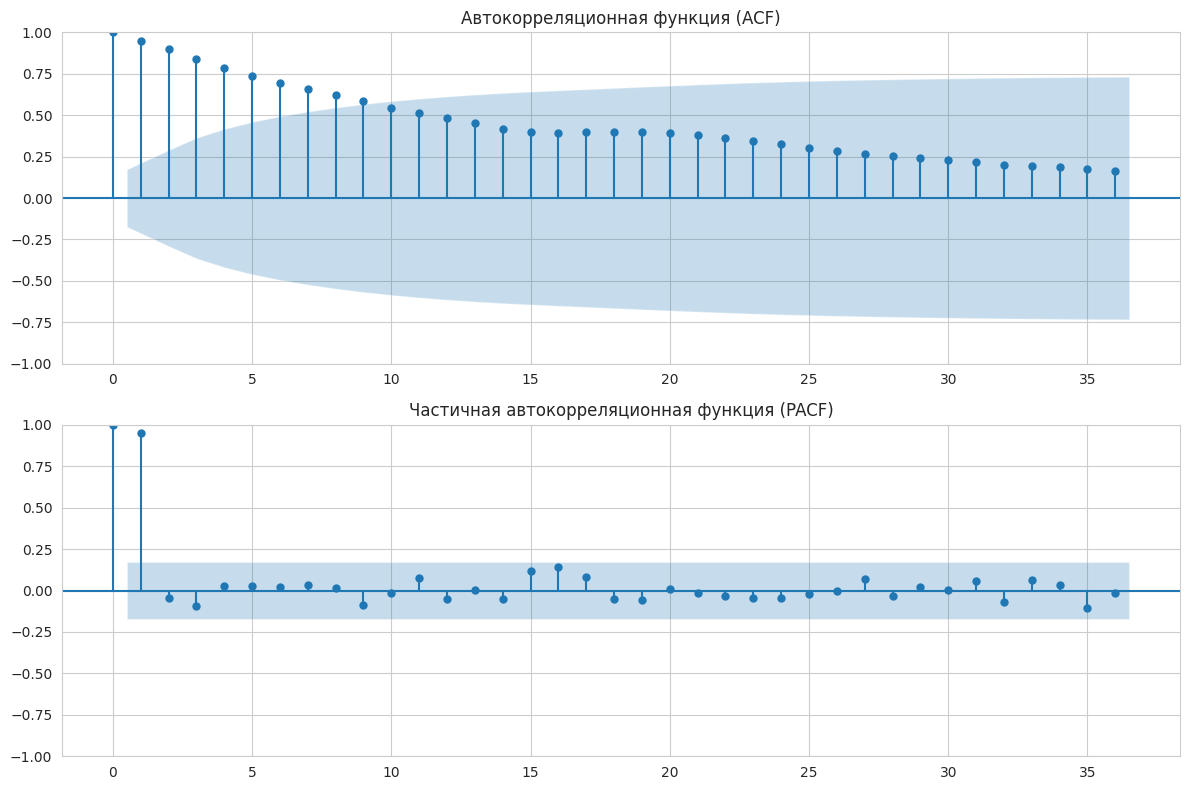

In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



Price_data = data['Price']

# Функция для тестирования на наличие сезонности и стационарности
def test_stationarity(data):
    adf_result = adfuller(data)
    kpss_result = kpss(data, regression='c')

    print('Тест Дики-Фуллера:')
    print(f'Статистика ADF: {adf_result[0]}, p-значение: {adf_result[1]}')

    print('Тест КПСС:')
    print(f'Статистика KPSS: {kpss_result[0]}, p-значение: {kpss_result[1]}')



# Визуализация временного ряда
def plot_time_series(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, marker='o', label='Средняя цена')
    plt.title('Средняя цена')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.grid()
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Построение графика ACF и PACF
def plot_acf_pacf(data, lags=36):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(data, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title('Автокорреляционная функция (ACF)')

    plot_pacf(data, lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title('Частичная автокорреляционная функция (PACF)')

    plt.tight_layout()
    plt.show()

# Выполнение анализа
plot_time_series(Price_data)
test_stationarity(Price_data)
plot_acf_pacf(Price_data)

Тест Дики-Фуллера (ADF):Поскольку p-значение (0.4726) значительно больше уровня значимости 0.05, мы не можем отвергнуть нулевую гипотезу о наличии единичного корня. Это означает, что временной ряд, скорее всего, не стационарен.

Тест КПСС: Здесь p-значение (0.01) меньше уровня значимости 0.05, что позволяет отвергнуть нулевую гипотезу о стационарности временного ряда. Это указывает на то, что ряд не является стационарным.

Общий вывод: Оба теста подтверждают, что временной ряд не является стационарным. Тест Дики-Фуллера указывает на наличие единичного корня, тогда как тест КПСС подтверждает, что ряд имеет тренд или другие нестационарные характеристики.


Forecasted Values:
Day 1: 5998.69
Day 2: 5998.66
Day 3: 6006.61
Day 4: 6005.19
Day 5: 6026.95
Day 6: 6046.72
Day 7: 6044.37


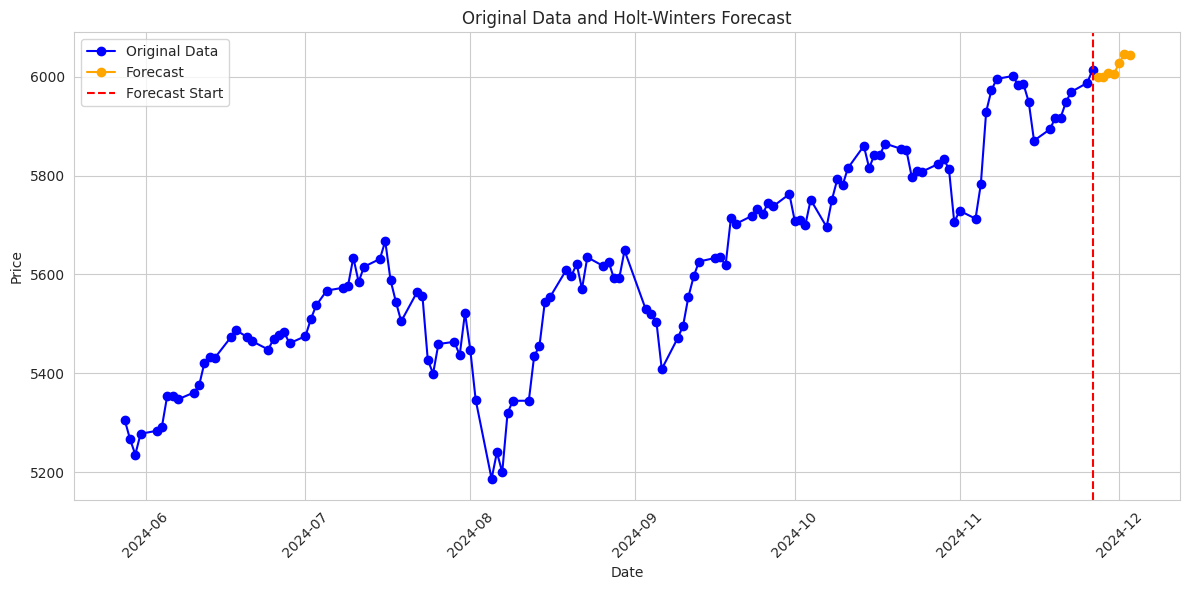

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class HoltWinters:
    def __init__(self, alpha, beta, gamma, seasonal_periods):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.seasonal_periods = seasonal_periods

    def fit(self, y):
        n = len(y)
        self.level = y[0]
        self.trend = y[1] - y[0]
        self.seasonal = [y[i] - self.level for i in range(self.seasonal_periods)]

        self.forecasts = []
        for t in range(n):
            if t == 0:
                forecast = self.level + self.trend + self.seasonal[t % self.seasonal_periods]
            else:
                forecast = (self.level + self.trend) + self.seasonal[t % self.seasonal_periods]

            self.forecasts.append(forecast)

            prev_level = self.level
            self.level = (self.alpha * y[t]) + ((1 - self.alpha) * (self.level + self.trend))
            self.trend = (self.beta * (self.level - prev_level)) + ((1 - self.beta) * self.trend)
            self.seasonal[t % self.seasonal_periods] = (self.gamma * (y[t] - self.level)) + ((1 - self.gamma) * self.seasonal[t % self.seasonal_periods])

    def predict(self, periods):
        last_level = self.level
        last_trend = self.trend
        seasonal = self.seasonal.copy()

        predictions = []
        for i in range(periods):
            forecast = last_level + last_trend + seasonal[(len(predictions) + len(seasonal)) % len(seasonal)]
            predictions.append(forecast)
            last_level += last_trend

        return predictions

def main(data, alpha=0.2, beta=0.1, gamma=0.3, seasonal_periods=7, forecast_periods=7):
    # Сортировка данных по дате
    data['Data'] = pd.to_datetime(data['Data'])
    data.sort_values('Data', inplace=True)

    y = data['Price'].values
    model = HoltWinters(alpha, beta, gamma, seasonal_periods)
    model.fit(y)

    # Прогнозирование
    forecasts = model.predict(forecast_periods)
    print("\nForecasted Values:")
    for i, forecast in enumerate(forecasts):
        print(f"Day {i+1}: {forecast:.2f}")
    # Визуализация исходных данных и прогноза на одном графике
    plt.figure(figsize=(12, 6))
    plt.plot(data['Data'], y, label='Original Data', color='blue', marker='o')

    # Создание индекса для прогнозируемых значений с дневной частотой
    forecast_index = pd.date_range(start=data['Data'].iloc[-1] + pd.DateOffset(days=1), periods=forecast_periods, freq='D')

    plt.plot(forecast_index, forecasts, label='Forecast', color='orange', marker='o')

    plt.title('Original Data and Holt-Winters Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.axvline(x=data['Data'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Запуск модели
main(data, alpha=0.2, beta=0.1, gamma=0.3, seasonal_periods=6, forecast_periods=7)

Тюнинг

Best parameters: {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.1, 'seasonal_periods': 14}
Best score (RMSE): 109.74194078070438

Model Parameters:
Alpha: 0.6
Beta: 0.6
Gamma: 0.1
Last Seasonal Coefficient: 49.35884677154211

Forecasted Values:
Day 1: 6042.68
Day 2: 6060.37
Day 3: 6067.45
Day 4: 6102.51
Day 5: 6126.38
Day 6: 6155.74
Day 7: 6214.27
Day 8: 6235.09
Day 9: 6262.14
Day 10: 6303.12


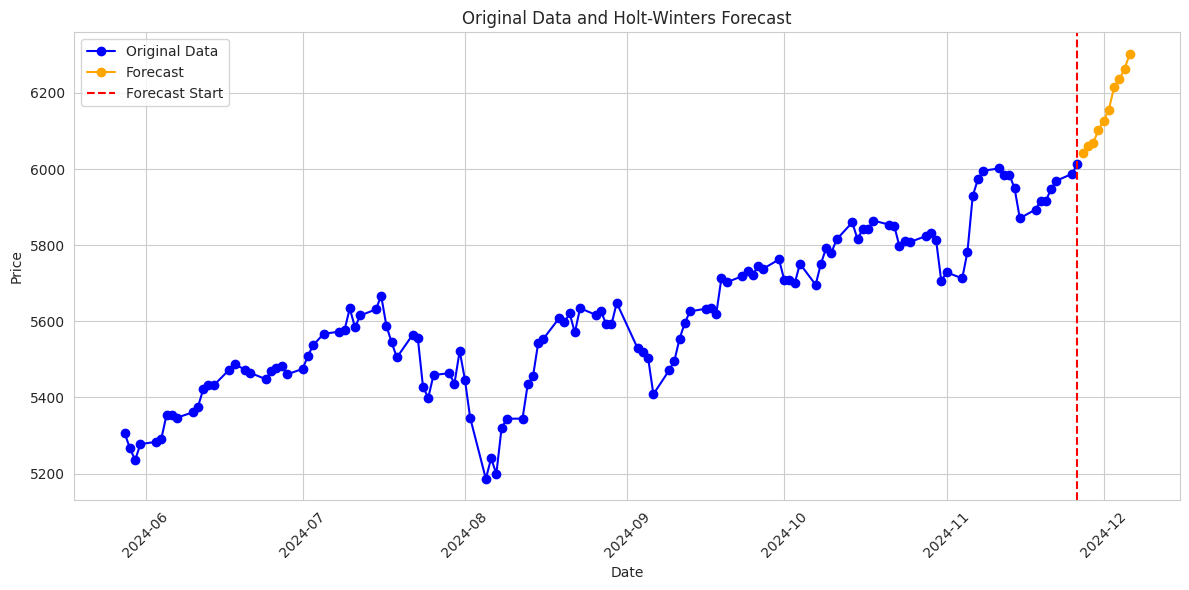

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

class HoltWinters:
    def __init__(self, alpha, beta, gamma, seasonal_periods):
        """Инициализация параметров модели Хольта-Уинтерса."""
        self.alpha = alpha  # Параметр сглаживания уровня
        self.beta = beta    # Параметр сглаживания тренда
        self.gamma = gamma   # Параметр сглаживания сезонности
        self.seasonal_periods = seasonal_periods  # Период сезонности

    def fit(self, y):
        """Обучение модели на временном ряде."""
        n = len(y)
        self.level = y[0]  # Начальное значение уровня
        self.trend = y[1] - y[0]  # Начальное значение тренда
        self.seasonal = [y[i] - self.level for i in range(self.seasonal_periods)]  # Начальные значения сезонности

        self.forecasts = []  # Список для хранения прогнозов
        for t in range(n):
            if t == 0:
                forecast = self.level + self.trend + self.seasonal[t % self.seasonal_periods]
            else:
                forecast = (self.level + self.trend) + self.seasonal[t % self.seasonal_periods]

            self.forecasts.append(forecast)  # Сохранение прогноза

            prev_level = self.level
            # Обновление уровня, тренда и сезонности
            self.level = (self.alpha * y[t]) + ((1 - self.alpha) * (self.level + self.trend))
            self.trend = (self.beta * (self.level - prev_level)) + ((1 - self.beta) * self.trend)
            self.seasonal[t % self.seasonal_periods] = (self.gamma * (y[t] - self.level)) + ((1 - self.gamma) * self.seasonal[t % self.seasonal_periods])

    def predict(self, periods):
        """Прогнозирование на заданное количество периодов."""
        last_level = self.level
        last_trend = self.trend
        seasonal = self.seasonal.copy()

        predictions = []
        for i in range(periods):
            forecast = last_level + last_trend + seasonal[(len(predictions) + len(seasonal)) % len(seasonal)]
            predictions.append(forecast)
            last_level += last_trend  # Обновление уровня для следующего прогноза

        return predictions

    def score(self, y_true, y_pred):
        """Оценка модели с использованием RMSE."""
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

def main(data, forecast_periods=7):
    """Основная функция для выполнения модели Хольта-Уинтерса."""
    # Сортировка данных по дате
    data['Data'] = pd.to_datetime(data['Data'])
    data.sort_values('Data', inplace=True)

    y = data['Price'].values  # Извлечение цен из данных

    # Параметры для GridSearch
    param_grid = {
        'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        'beta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        'seasonal_periods': [3,4,5,6,7,12,14]
    }

    best_score = float('inf')  # Инициализация лучшего значения ошибки
    best_params = {}  # Словарь для хранения лучших параметров

    # Кросс-валидация по временным рядам
    tscv = TimeSeriesSplit(n_splits=5)

    for seasonal_periods in param_grid['seasonal_periods']:
        for alpha in param_grid['alpha']:
            for beta in param_grid['beta']:
                for gamma in param_grid['gamma']:
                    model = HoltWinters(alpha, beta, gamma, seasonal_periods)
                    scores = []

                    for train_index, test_index in tscv.split(y):
                        train, test = y[train_index], y[test_index]
                        model.fit(train)  # Обучение модели на обучающей выборке
                        predictions = model.predict(len(test))  # Прогнозирование на тестовой выборке
                        score = model.score(test, predictions)  # Оценка модели
                        scores.append(score)

                    mean_score = np.mean(scores)  # Среднее значение ошибки
                    if mean_score < best_score:  # Если текущее значение лучше лучшего
                        best_score = mean_score
                        best_params = {
                            'alpha': alpha,
                            'beta': beta,
                            'gamma': gamma,
                            'seasonal_periods': seasonal_periods
                        }

    print("Best parameters:", best_params)  # Вывод лучших параметров
    print("Best score (RMSE):", best_score)  # Вывод лучшей ошибки

    # Обучение модели с лучшими параметрами на всех данных
    best_model = HoltWinters(**best_params)
    best_model.fit(y)

    # Прогнозирование
    forecasts = best_model.predict(forecast_periods)
        # Вывод параметров модели и прогнозных значений
    print("\nModel Parameters:")
    print(f"Alpha: {best_model.alpha}")
    print(f"Beta: {best_model.beta}")
    print(f"Gamma: {best_model.gamma}")
    print(f"Last Seasonal Coefficient: {best_model.seasonal[-1]}")

    print("\nForecasted Values:")
    for i, forecast in enumerate(forecasts):
        print(f"Day {i+1}: {forecast:.2f}")
    # Визуализация исходных данных и прогноза на одном графике
    plt.figure(figsize=(12, 6))
    plt.plot(data['Data'], y, label='Original Data', color='blue', marker='o')

    # Создание индекса для прогнозируемых значений с дневной частотой
    forecast_index = pd.date_range(start=data['Data'].iloc[-1] + pd.DateOffset(days=1), periods=forecast_periods, freq='D')

    plt.plot(forecast_index, forecasts, label='Forecast', color='orange', marker='o')

    plt.title('Original Data and Holt-Winters Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.axvline(x=data['Data'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


main(data, forecast_periods=10)
